## Well basics

Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import welly
welly.__version__

'0.1.0'

In [2]:
import os
env = %env

## Load a well

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [3]:
from welly import Well

In [4]:
w = Well.from_las('P-129_out.LAS')

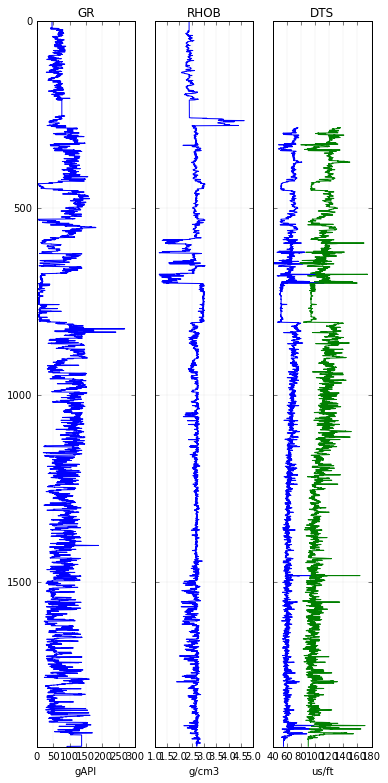

In [5]:
tracks = ['GR', 'RHOB', ['DT', 'DTS']]
w.plot(tracks=tracks)

## Add a striplog

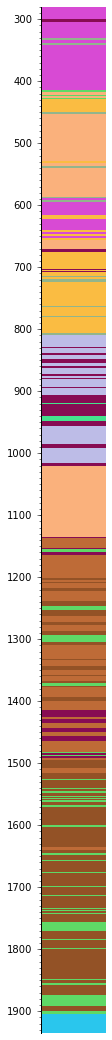

In [6]:
from striplog import Legend, Striplog
legend = Legend.builtin('NSDOE')
strip = Striplog.from_image('P-129_280_1935.png', 280, 1935, legend=legend)
strip.plot()

In [7]:
w.data['strip'] = strip

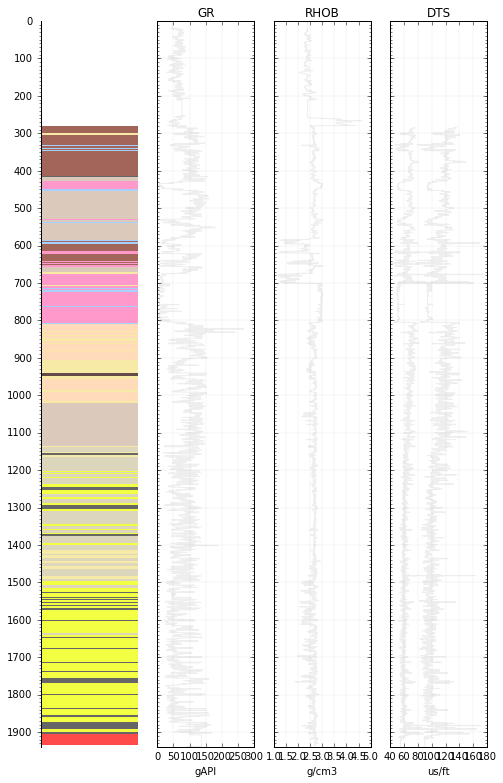

In [8]:
tracks = ['strip', 'GR', 'RHOB', ['DT', 'DTS']]
w.plot(tracks=tracks, legend=legend)

In [9]:
curve_legend_csv = """colour,lw,xscale,curve mnemonic
#ff0000,2.0,linear,GR
#000000,2.0,log,RHOB
#00ff00,2.0,linear,DT
#ffff00,3.0,linear,DTS
"""
curve_legend = Legend.from_csv(curve_legend_csv)
curve_legend

Legend(Decor({'hatch': None, 'colour': '#ff0000', 'width': None, 'xscale': 'linear', 'lw': 2.0, 'curve': Component({'mnemonic': 'gr'})})
Decor({'hatch': None, 'colour': '#000000', 'width': None, 'xscale': 'log', 'lw': 2.0, 'curve': Component({'mnemonic': 'rhob'})})
Decor({'hatch': None, 'colour': '#00ff00', 'width': None, 'xscale': 'linear', 'lw': 2.0, 'curve': Component({'mnemonic': 'dt'})})
Decor({'hatch': None, 'colour': '#ffff00', 'width': None, 'xscale': 'linear', 'lw': 3.0, 'curve': Component({'mnemonic': 'dts'})}))

In [10]:
complete_legend = legend + curve_legend

In [11]:
complete_legend.get_decor(w.data['GR'])

hatch,None
colour,#ff0000
width,None
xscale,linear
lw,2.0
curve,{'mnemonic': 'gr'}


/Users/matt/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


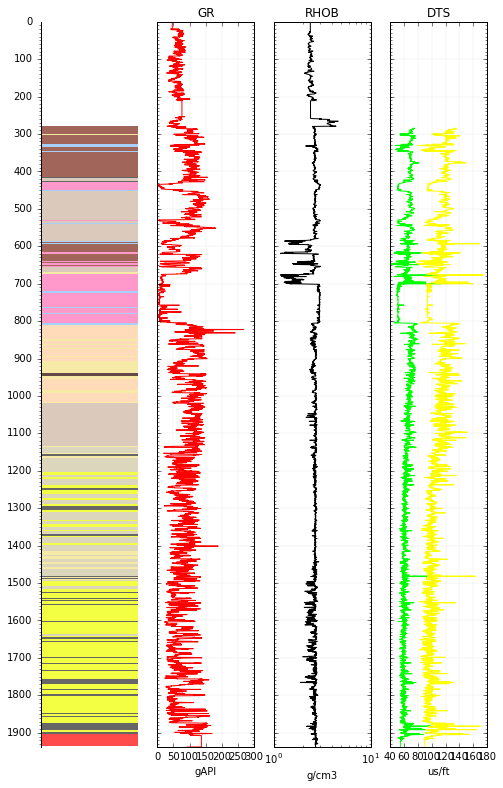

In [21]:
w.plot(tracks=tracks, legend=complete_legend)

## Load another well

In [13]:
canstrat = 'Dropbox/Agile/Canstrat/Sample_LAS_from_Canstrat/EC00001_CS/'
x = Well.from_las(os.path.join(env['HOME'], canstrat, 'EC00001_CS_main.LAS'))

In [14]:
x.header

{'uwi': inf, 'name': 'SHELL ONONDAGA E-84'}

In [15]:
x

## Add data

In [16]:
len(x.data)

23

In [17]:
fname = '/Users/matt/Dropbox/Agile/Canstrat/Sample_LAS_from_Canstrat/EC00001_CS/EC00001_CS_diagen_ind.LAS'
x.add_curves_from_las(fname)

In [18]:
len(x.data)

34

## Save LAS file

In [22]:
w.to_las('out.las')

## Header

Maybe should be called 'meta' as it's not really a header... 

In [20]:
w.header

{'uwi': "Long = 63* 45'24.460  W", 'name': 'Kennetcook #2', 'license': 'P-129', 'field': 'Windsor Block'}

In [18]:
w.header.name

'SHELL ONONDAGA E-84'

In [19]:
w.uwi  # Fails because not present in this file. See one way to add it in a minute.

inf

## Location and CRS

In [15]:
w.location

Location({'kb': 25.9, 'longitude': 60.221388, 'td': '3,988.3', 'tdl': '3,988.3', 'latitude': 43.721111, 'crs': CRS({}), 'datum': 'NAD83', 'tdd': '3,988.3'})

In [16]:
w.location.crs

CRS({})

In [17]:
from welly import CRS
w.location.crs = CRS.from_epsg(2038)

In [18]:
w.location

Location({'crs': CRS({'no_defs': True, 'init': 'epsg:2038'}), 'tdl': '3,988.3', 'latitude': 43.721111, 'datum': 'NAD83', 'longitude': 60.221388, 'kb': 25.9, 'tdd': '3,988.3', 'td': '3,988.3'})

## Coping with messy LAS

Some file headers are a disgrace:

    # LAS format log file from PETREL
    # Project units are specified as depth units
    #==================================================================
    ~Version information
    VERS.   2.0:
    WRAP.   YES:
    #==================================================================
    ~WELL INFORMATION
    #MNEM.UNIT      DATA             DESCRIPTION
    #---- ------ --------------   -----------------------------
    STRT .M      1.0668          :START DEPTH     
    STOP .M      1939.13760      :STOP DEPTH     
    STEP .M       0.15240        :STEP        
    NULL .          -999.25      :NULL VALUE
    COMP .        Elmworth Energy Corporation              :COMPANY
    WELL .        Kennetcook #2                            :WELL
    FLD  .        Windsor Block                            :FIELD
    LOC  .        Lat = 45* 12' 34.237" N                  :LOCATION
    PROV .        Nova Scotia                              :PROVINCE
      UWI.        Long = 63* 45'24.460  W                  :UNIQUE WELL ID
    LIC  .        P-129                                    :LICENSE NUMBER
    CTRY .        CA                                       :COUNTRY (WWW code)
     DATE.        10-Oct-2007                              :LOG DATE {DD-MMM-YYYY}
    SRVC .        Schlumberger                             :SERVICE COMPANY
    LATI .DEG                                              :LATITUDE
    LONG .DEG                                              :LONGITUDE
    GDAT .                                                 :GeoDetic Datum
    SECT .        45.20 Deg N                              :Section
    RANG .        PD 176                                   :Range
    TOWN .        63.75 Deg W                              :Township

In [19]:
import welly
import re

def transform_ll(text):
    def callback(match):
        d = match.group(1).strip()
        m = match.group(2).strip()
        s = match.group(3).strip()
        c = match.group(4).strip()
        if c.lower() in ('w', 's') and d[0] != '-':
            d = '-' + d
        return ' '.join([d, m, s])
    pattern = re.compile(r""".+?([-0-9]+?).? ?([0-9]+?).? ?([\.0-9]+?).? +?([NESW])""", re.I)
    text = pattern.sub(callback, text)
    return welly.utils.dms2dd([float(i) for i in text.split()])

In [20]:
print(transform_ll("""Lat = 45* 12' 34.237" N"""))
print(transform_ll("""Long = 63* 45'24.460  W"""))

45.20951027777778
-62.243205555555555


In [21]:
remap = {
    'LATI': 'LOC',  # Use LOC for the parameter LATI.
    'LONG': 'UWI',  # Use UWI for the parameter LONG.
    'SECT': None,   # Use nothing for the parameter SECT.
    'RANG': None,   # Use nothing for the parameter RANG.
    'TOWN': None,   # Use nothing for the parameter TOWN.
}

funcs = {
    'LATI': transform_ll,  # Pass LATI through this function before loading.
    'LONG': transform_ll,  # Pass LONG through it too.
    'UWI': lambda x: "No name, oh no!"
}

In [22]:
w = Well.from_las('P-129_out.LAS', remap=remap, funcs=funcs)

In [23]:
w.location  # Should not contain SECT, RANG or TOWN

Location({'kb': 94.8, 'crs': CRS({}), 'tdl': 1935.0, 'latitude': 45.20951027777778, 'country': 'CA', 'tdd': 1935.0, 'td': 1935.0, 'longitude': -62.243205555555555})

In [24]:
w.uwi

'No name, oh no!'

## Curves

Just a list of objects.

In [25]:
w.data  # Just a dict of data objects.

{'CALI': Curve([ 2.44381547,  2.44381547,  2.44381547, ...,  2.42026806,
         2.42026806,  2.42026806]),
 'DEPT': Curve([  1.06680000e+00,   1.21920000e+00,   1.37160000e+00, ...,
          1.93883280e+03,   1.93898520e+03,   1.93913760e+03]),
 'DPHI_DOL': Curve([  2.59099990e-01,   2.59099990e-01,   2.59099990e-01, ...,
          5.41675720e+02,   5.41675720e+02,   5.41675720e+02]),
 'DPHI_LIM': Curve([  1.98440000e-01,   1.98440000e-01,   1.98440000e-01, ...,
          5.85941528e+02,   5.85941528e+02,   5.85941528e+02]),
 'DPHI_SAN': Curve([ 0.15748   ,  0.15748   ,  0.15748   , ...,  0.54641998,
         0.54641998,  0.54641998]),
 'DRHO': Curve([ 0.19423294,  0.19423294,  0.19423294, ...,  0.06139515,
         0.06139515,  0.06139515]),
 'DT': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'DTS': Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 'GR': Curve([ 46.69865036,  46.69865036,  46.69865036, ...,  92.24622345,
         92.24622345,  92.24622345]),
 'HCAL': Curve([

In Jupyter Notebook, the `__repr__()` is a little table summarizing the curve data...

In [26]:
gr = w.data['GR']
gr

Curve([ 46.69865036,  46.69865036,  46.69865036, ...,  92.24622345,
        92.24622345,  92.24622345])

`Curve` objects are just `ndarray`s, so we get lots of things for free...

In [27]:
m = np.mean(gr)

In [28]:
m  # Not really sure why this is a Curve

Curve(78.9863535887685)

In [29]:
gr.mnemonic

'GR'

## Using Legend

In [30]:
legend_csv = """curve mnemonic,track,xleft,xright,xticks,xlabel_fmt,midline,logarithmic,linecolor,colour,fill_left_cond,fill_left,fill_right_color
GR,0,0,210,"30,60,90,120,150,180",int,,linear,black,g,xleft,#FFFFFF,
CALI,0,4,14,"4,14",,,linear,light grey,#D3D3D3,,,
PEF,0,0,20,"0,10,20",,,linear,plum,#EAADEA,,,
SP,0,0,100,"25,50,75",,,linear,sap green,#308014,,,
RLA5,1,0.02,2000,"0.2,2.0,20,200",,,log,black,#000000,,,#F3F3F3
RLA4,1,0.02,2000,"0.2,2.0,20,200",,,log,black,#000000,,,#F3F3F3"""

In [31]:
from striplog import Legend
l = Legend.from_csv(legend_csv)

In [32]:
l.get_decor(gr)

Getting for other


colour,#00ff00
logarithmic,linear
xlabel_fmt,int
xticks,"30,60,90,120,150,180"
fill_left,#ffffff
fill_right_color,
width,None
xright,210.0
fill_left_cond,xleft
curve,{'mnemonic': 'gr'}
xleft,0.0


## Units

`welly` does not deal in a smart way with units. 

We recommend `pint` for now. At some point we may intergate its behaviour into `welly`. 

In [33]:
w.data['RHOB']

Curve([ 2.39014983,  2.39014983,  2.39014983, ...,         nan,
               nan,         nan])

In [34]:
import pint
ureg = pint.UnitRegistry()

rhob_old = ureg.Quantity(w.data['RHOB'], 'g/cm^3')
rhob_new = rhob_old.to('kg/m^3')

print(rhob_new)

[ 2390.1498318  2390.1498318  2390.1498318 ...,           nan           nan           nan] kilogram / meter ** 3


In [35]:
rhob_new.units

<Unit('kilogram / meter ** 3')>

## Plotting and reading

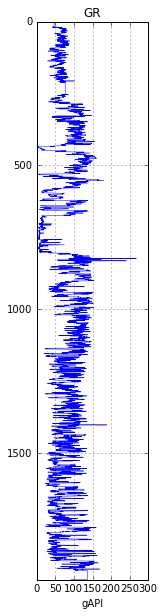

In [36]:
gr.plot(lw=0.5)

In [37]:
gr.read_at(1001)

97.991123408843123

In [38]:
gr.read_at([1001, 1003, 1004])

array([  97.99112341,  116.8162655 ,  104.1488654 ])

In [39]:
gr.stop

1939.2900000000002

## Changing basis

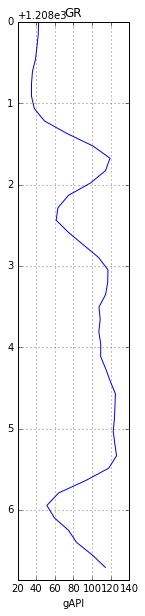

In [40]:
newb = gr.new_basis(start=1208, stop=1215)
newb.plot()

## Getting a segment of the data

In [41]:
segment = gr.new_basis(600, 680)

In [42]:
segment.basis[-1]

679.55279999997038

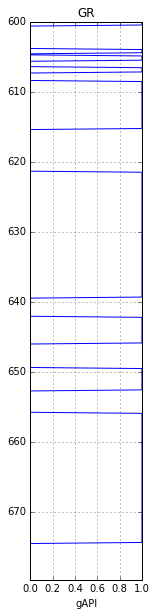

In [43]:
segment.block(cutoffs=50).plot()

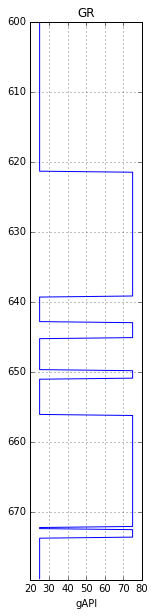

In [44]:
segment.block(values=(25, 75)).plot()

You can use a cutoff of, say, 50 API, then reassign the output values to whatever you like:

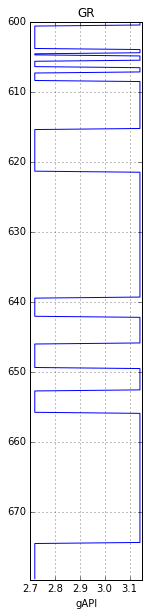

In [45]:
segment.block(cutoffs=50, values=(2.718, 3.142)).plot()

You can send a function in to determine replacement values from the original log. E.g., to replace the values with the block means:

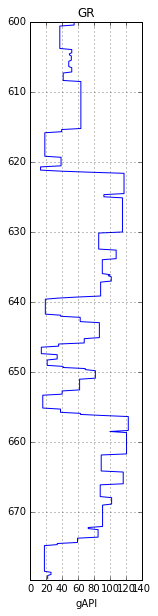

In [46]:
segment.block(cutoffs=[25, 50, 75, 100], function=np.mean).plot()

## Applying a function

In [47]:
def gardner(vp, alpha=0.31, beta=0.25):
    return alpha * vp ** beta

dt = w.data['DT']
vp = 1000000 / dt
vp.apply(gardner)

Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan])

## Not implemented yet

PUT WISHED-FOR APIS HERE.